# Quantitative Mean-Reversion Strategy: Algorithmic Pairs Trading in Python
This project implements an algorithmic trading strategy focused on Statistical Arbitrage (Pairs Trading). By utilizing the Engle-Granger two-step method, the system identifies equity pairs that exhibit a long-term cointegrated relationship, distinguishing them from pairs that are merely correlated. The strategy calculates a dynamic hedge ratio using OLS (Ordinary Least Squares) regression to construct a market-neutral spread. Trade signals are generated based on normalized Z-score deviations from the mean, exploiting temporary pricing inefficiencies. The system includes a backtesting engine that simulates historical performance, accounting for transaction costs to validate the strategy's viability in a realistic market environment.

### Loading Tickers + Plotting Movement

[*********************100%***********************]  2 of 2 completed

Ticker           BZ=F       CL=F
Date                            
2010-01-04  80.120003  81.510002
2010-01-05  80.589996  81.769997
2010-01-06  81.889999  83.180000
2010-01-07  81.510002  82.660004
2010-01-08  81.370003  82.750000


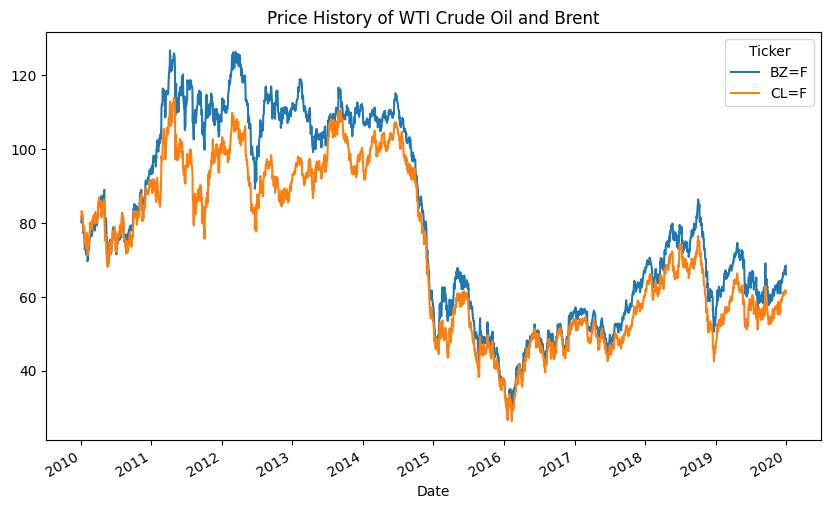

In [66]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['CL=F', 'BZ=F']
start_date = '2010-01-01'
end_date = '2020-01-01'

data = yf.download(tickers, start = start_date, end = end_date, auto_adjust = False)['Adj Close']
print(data.head())
data = data.dropna()

data.plot(figsize = (10, 6))
plt.title('Price History of WTI Crude Oil and Brent')
plt.show()

### Correlation vs Cointegration

- Correlation refers to the movement of the stocks in relation to each other
- Cointegration refers to the distance between the two stocks and if that remains constant over time

We will use the Engle-Granger Test to test for stationarity in the residuals.
- The Engle-Granger Test checks to see if the spread between two stocks is stationary

It is otherwise known as the "Two-Step" method because it does two things:
- 1: Regression. It tries to find the best equation to overlay stock A onto stock B
- 2: Stationarity. It runs an "Augmented Dickey-Fuller" test on the residuals.

In [67]:
import statsmodels.tsa.stattools as ts

s1 = data['CL=F']
s2 = data['BZ=F']

score, pvalue, _ = ts.coint(s1, s2)

print(f"Cointegration P-value: {pvalue:.5f}")

if pvalue < 0.05:
    print("Result: The pair is statistically likely to be Cointegrated")
else:
    print("Result: The pair is NOT Cointegrated.")

Cointegration P-value: 0.01229
Result: The pair is statistically likely to be Cointegrated


### The Hedge Ratio

Since WTI and Brent trade at different prices, we will use Linear Regression (OLS) to find the "Hedge Ratio" (Beta).

Formula: WTI = beta x Brent + Spread

This will prevent us from the exposure to the price of the oil itself.

- I want to note I attempted KO-PEP, EWA-EWC, and GOOG-GOOGL pairs, but all were found to have p-values above 0.05 and are likely to not be Cointegrated. CL and BRN have a p-value of 0.03053 (<0.05) and hence we will use this pair for the analysis.

Hedge Ratio:  0.8348
Interpretation: For every 1 unit of CL (WTI) you buy, you should sell  0.835 units of BRN (brent).
Line equation --> y = WTI -  0.835 * Brent


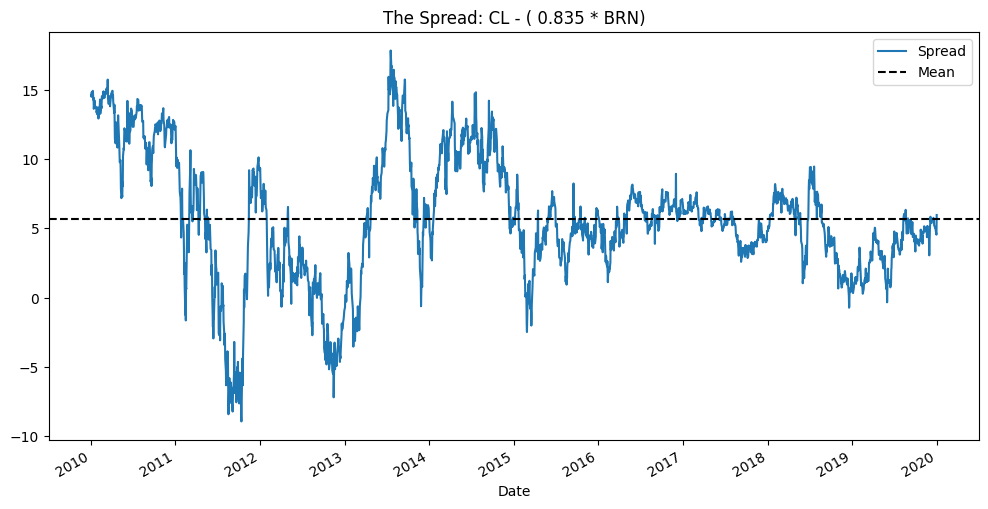

In [68]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

s2_const = sm.add_constant(s2)
model = sm.OLS(s1, s2_const)
results = model.fit()
hedge_ratio = results.params.iloc[1]

print(f'Hedge Ratio: {hedge_ratio: .4f}')
print(f'Interpretation: For every 1 unit of CL (WTI) you buy, you should sell {hedge_ratio: .3f} units of BRN (brent).')
print(f'Line equation --> y = WTI - {hedge_ratio: .3f} * Brent') 

spread = s1 - (hedge_ratio * s2)

plt.figure(figsize = (12, 6))
spread.plot(label = 'Spread')
plt.axhline(spread.mean(), color = 'black' , linestyle = '--', label = 'Mean')
plt.title(f'The Spread: CL - ({hedge_ratio: .3f} * BRN)')
plt.legend()
plt.show()

### Trade Signal Generation (Z-Score)

Now we will convert the raw dollar value of the spread into a normalized Z-Score
- This will allow us to see just how much the spread is deviated, hence we can find the rare events (When Z > 1.5 or Z < -1.5), becaus statistically, they are likely to snap back to 0.

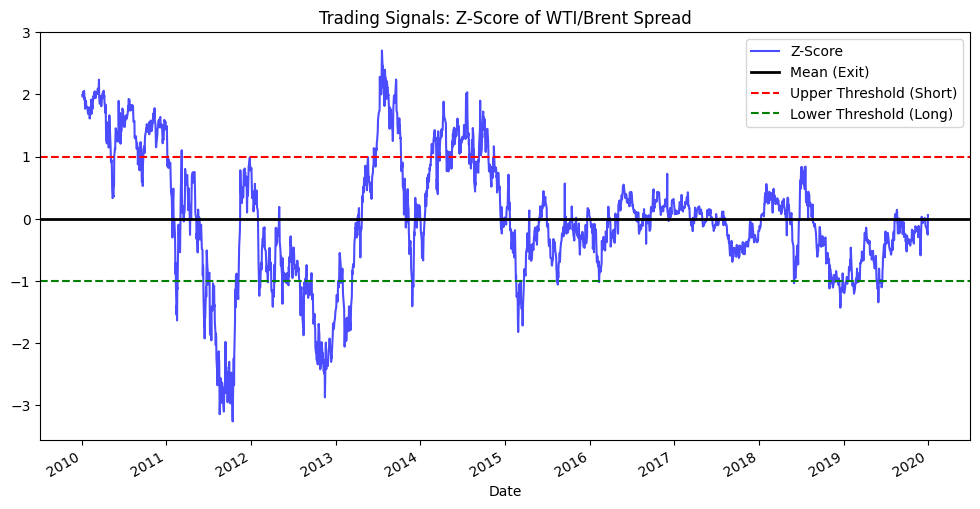

In [69]:
z_score = (spread - spread.mean()) / spread.std()

plt.figure(figsize = (12, 6))
z_score.plot(label = 'Z-Score', color = 'blue', alpha = 0.7)

## Threshold Lines
plt.axhline(0, color = 'black', lw = 2, linestyle = '-', label = 'Mean (Exit)')
plt.axhline(1.0, color = 'red', linestyle = '--', label = 'Upper Threshold (Short)')
plt.axhline(-1.0, color = 'green', linestyle = '--', label = 'Lower Threshold (Long)')

plt.title('Trading Signals: Z-Score of WTI/Brent Spread')
plt.legend(loc = 'best')
plt.show()

### Backtesting

[*********************100%***********************]  2 of 2 completed


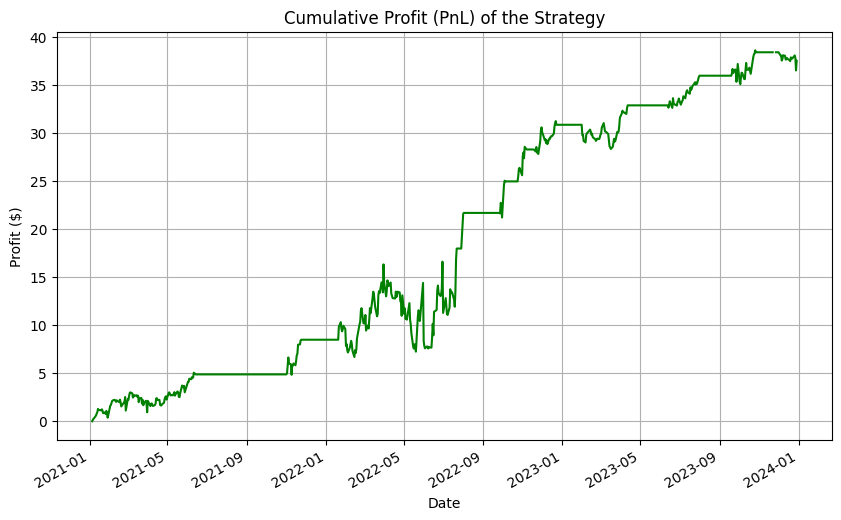

In [72]:
oos_start = '2021-01-01'
oos_end = '2024-01-01'

data_oos = yf.download(tickers, start = oos_start, end = oos_end, auto_adjust = False)['Adj Close']

s1_oos = data_oos['CL=F']
s2_oos = data_oos['BZ=F']

spread_oos = s1_oos - (hedge_ratio * s2_oos)
z_score_oos = (spread_oos - spread_oos.mean()) / spread_oos.std()

trades_oos = pd.DataFrame(index = z_score_oos.index)
trades_oos['Z_Score'] = z_score_oos
trades_oos['Spread'] =  spread_oos
trades_oos['Position'] = 0
trades_oos['PnL'] = 0.0

entry_threshold = 1.0
exit_threshold = 0.0
current_position = 0

for i in range(1, len(trades_oos)):
    z = trades_oos['Z_Score'].iloc[i-1]

    if current_position == 0:
        if z > entry_threshold:
            current_position = -1
        elif z < -entry_threshold:
            current_position = 1
            
    elif current_position == -1:
        if z <= exit_threshold:
            current_position = 0

    elif current_position == 1:
        if z >= exit_threshold:
            current_position = 0

    trades_oos.loc[trades_oos.index[i], 'Position'] = current_position

## Calculating Profit: Daily PnL = Position * (Price Change of Spread)
trades_oos['PnL'] = trades_oos['Position'].shift(1) * (trades_oos['Spread'] - trades_oos['Spread'].shift(1))

## Cumulative Profit
trades_oos['Cumulative_PnL'] = trades_oos['PnL'].cumsum()

plt.figure(figsize = (10, 6))
trades_oos['Cumulative_PnL'].plot(color = 'green')
plt.title('Cumulative Profit (PnL) of the Strategy')
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.grid()
plt.show()

In [77]:
## Accounting for Transaction Costs

trade_counts = trades_oos['Position'].diff().abs().sum()

cost_per_trade = 1.00
total_costs = trade_counts * cost_per_trade

net_profit = trades_oos['Cumulative_PnL'].iloc[-1] - total_costs

print(f"Total Trades: {trade_counts}")
print(f"Gross Profit: ${trades_oos['Cumulative_PnL'].iloc[-1]:.2f}")
print(f'Total Transaction Costs: ${total_costs: .2f}')
print('-'*50)
print(f'Net Profit: ${net_profit: .2f}')

Total Trades: 23.0
Gross Profit: $37.49
Total Transaction Costs: $ 23.00
--------------------------------------------------
Net Profit: $ 14.49
